# Laboratorio: Modelos del lenguaje con RNNs

## Integrantes: Kevin Calle, Veronica Chimbo, Javier Parra
## Fecha: 10 dicembre de 2018



                   
                   
En este laboratorio, vamos a entrenar un modelo del lenguaje basado en caracteres con Recurrent Neural Networks. Asimismo, utilizaremos el modelo para generar texto. En particular, alimentaremos nuestro modelo con obras de la literatura clásica en castellano para obtener una red neuronal que sea capaz de "escribir" fragmentos literarios.

Los entrenamientos en esta laboratorio para obtener un modelo de calidad podrían tomar cierto tiempo (5-10 minutos por epoch), por lo que se aconseja empezar a trabajar pronto. El uso de GPUs no ayuda tanto con LSTMs como con CNNs, por lo que si tenéis máquinas potentes en casa es posible que podáis entrenar más rápido o a la misma velocidad que en Colab. En todo caso, la potencia de Colab es más que suficiente para completar este laboratorio con éxito.

<center><img src="https://upload.wikimedia.org/wikipedia/commons/d/d8/El_ingenioso_hidalgo_don_Quijote_de_la_Mancha.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consistirá en un archivo de texto con el contenido íntegro en castellano antiguo de El Ingenioso Hidalgo Don Quijote de la Mancha, disponible de manera libre en la página de [Project Gutenberg](https://www.gutenberg.org). Asimismo, como apartado optativo en este laboratorio se pueden utilizar otras fuentes de texto. Aquí podéis descargar los datos a utilizar de El Quijote y un par de obras adicionales:

[El ingenioso hidalgo Don Quijote de la Mancha (Miguel de Cervantes)](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219424&authkey=AH0gb-qSo5Xd7Io)

[Compilación de obras teatrales (Calderón de la Barca)](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219433&authkey=AKvGD6DC3IRBqmc)

[Trafalgar (Benito Pérez Galdós)](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219434&authkey=AErPCAtMKOI5tYQ)

Como ya deberíamos de estar acostumbrados en problemas de Machine Learning, es importante echar un vistazo a los datos antes de empezar.

## 1. Carga y procesado del texto

Primero, vamos a descargar el libro e inspeccionar los datos. El fichero a descargar es una versión en .txt del libro de Don Quijote, a la cual se le han borrado introducciones, licencias y otras secciones para dejarlo con el contenido real de la novela.

In [0]:
# Se importan las librerías necesarias

import numpy as np 
import keras
import matplotlib.pyplot as plt
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
import random
import io
import pandas as pd
import sys
seed = 1234

Using TensorFlow backend.


In [0]:
# Se descarga el texto de Don Quijote de la mancha

path = keras.utils.get_file(
    fname="don_quijote.txt", 
    origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219424&authkey=AH0gb-qSo5Xd7Io"
)

Una vez descargado, vamos a leer el contenido del fichero en una variable. Adicionalmente, convertiremos el contenido del texto a minúsculas para ponérselo un poco más fácil a nuestro modelo (de modo que todas las letras sean minúsculas y el modelo no necesite diferenciar entre minúsculas y mayúsculas).

**1.1.** Leer todo el contenido del fichero en una única variable ***text*** y convertir el string a minúsculas

In [0]:
text = open(path,"r", encoding = 'utf-8').read().lower() # abrir archivo, leer archivo, y pasar todo a minusculas, acentos (utf-8)

Podemos comprobar ahora que efectivamente nuestra variable contiene el resultado deseado, con el comienzo tan característico del Quijote.

In [0]:
#¿a que nos enfrentamos, ¿cómo es la data?
print("Longitud del texto:", len(text), "caracteres")
print(text[0:110]) # Muestra archivo 100 caracteres
#text =text[0:207119] # para pruebas vamos a utilizar el 10% del texto

Longitud del texto: 2071198 caracteres
capítulo primero. que trata de la condición y ejercicio del famoso hidalgo
don quijote de la mancha


en un lu


## 2. Procesado de los datos

Una de las grandes ventajas de trabajar con modelos que utilizan caracteres en vez de palabras es que no necesitamos tokenizar el texto (partirlo palabra a palabra). Nuestro modelo funcionará directamente con los caracteres en el texto, incluyendo espacios, saltos de línea, etc.

Antes de hacer nada, necesitamos procesar el texto en entradas y salidas compatibles con nuestro modelo. Como sabemos, un modelo del lenguaje con RNNs acepta una serie de caracteres y predice el siguiente carácter en la secuencia.

* "*El ingenioso don Qui*" -> predicción: **j**
* "*El ingenioso don Quij*" -> predicción: **o**

De modo que la entrada y la salida de nuestro modelo necesita ser algo parecido a este esquema. En este punto, podríamos usar dos formas de preparar los datos para nuestro modelo.

1. **Secuencia a secuencia**. La entrada de nuestro modelo sería una secuencia y la salida sería esa secuencia trasladada un caracter a la derecha, de modo que en cada instante de tiempo la RNN tiene que predecir el carácter siguiente. Por ejemplo:

>* *Input*:   El ingenioso don Quijot 
>* *Output*: l ingenioso don Quijote

2. **Secuencia a carácter**. En este variante, pasaríamos una secuencia de caracteres por nuestra RNN y, al llegar al final de la secuencia, predeciríamos el siguiente carácter.

>* *Input*:   El ingenioso don Quijot 
>* *Output*: e

En este laboratorio, por simplicidad, vamos a utilizar la segunda variante.

De este modo, a partir del texto, hemos de generar nuestro propio training data que consista en secuencias de caracteres con el siguiente carácter a predecir. Para estandarizar las cosas, utilizaremos secuencias de tamaño *SEQ_LENGTH* caracteres (un hiperparámetro que podemos elegir nosotros).



#### 2.1. Obtención de los caracteres y mapas de caracteres

Antes que nada, necesitamos saber qué caracteres aparecen en el texto, ya que tendremos que diferenciarlos mediante un índice de 0 a *num_chars* - 1 en el modelo. Obtener:
 

1.   Número de caracteres únicos que aparecen en el texto.
2.   Diccionario que asocia char a índice único entre 0 y *num_chars* - 1. Por ejemplo, {'a': 0, 'b': 1, ...}
3.   Diccionario reverso de índices a caracteres: {0: 'a', 1: 'b', ...}


In [0]:
# 1. Número de caracteres únicos que aparecen en el texto

chars = sorted(set(text)) # total de caracteres únicos-> crea un conjunto no tiene elemento repetidos y lo ordenamos, tokenización pero con caracteres!
print('Total de carácteres únicos:', len(chars))
print (chars)

# 2. Diccionario que asocia char a índice único entre 0 y num_chars - 1. Por ejemplo, {'a': 0, 'b': 1, ...}

char_index = dict((c, i) for i, c in enumerate(chars)) 
print ("\nDiccionario caracter(char) - indice(int):", char_int)

# 3. Diccionario reverso de índices a caracteres: {0: 'a', 1: 'b', ...}

index_char = dict((i, c) for i, c in enumerate(chars))
print ("\nDiccionario indice(int) - caracter(char): ", int_char)

Total de carácteres únicos: 61
['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', ':', ';', '?', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¡', '«', '»', '¿', 'à', 'á', 'é', 'í', 'ï', 'ñ', 'ó', 'ù', 'ú', 'ü']

Diccionario caracter(char) - indice(int): {'\n': 0, ' ': 1, '!': 2, '"': 3, "'": 4, '(': 5, ')': 6, ',': 7, '-': 8, '.': 9, '0': 10, '1': 11, '2': 12, '3': 13, '4': 14, '5': 15, '6': 16, '7': 17, ':': 18, ';': 19, '?': 20, ']': 21, 'a': 22, 'b': 23, 'c': 24, 'd': 25, 'e': 26, 'f': 27, 'g': 28, 'h': 29, 'i': 30, 'j': 31, 'l': 32, 'm': 33, 'n': 34, 'o': 35, 'p': 36, 'q': 37, 'r': 38, 's': 39, 't': 40, 'u': 41, 'v': 42, 'w': 43, 'x': 44, 'y': 45, 'z': 46, '¡': 47, '«': 48, '»': 49, '¿': 50, 'à': 51, 'á': 52, 'é': 53, 'í': 54, 'ï': 55, 'ñ': 56, 'ó': 57, 'ù': 58, 'ú': 59, 'ü': 60}

Diccionario indice(int) - caracter(char):  {0: '\n', 1: ' ', 2: '!', 3: '"', 

#### 2.2. Obtención de secuencias de entrada y carácter a predecir

Ahora, vamos a obtener las secuencias de entrada en formato texto y los correspondientes caracteres a predecir. Para ello, recorrer el texto completo leído anteriormente, obteniendo una secuencia de SEQ_LENGTH caracteres y el siguiente caracter a predecir. Una vez hecho, desplazarse un carácter a la izquierda y hacer lo mismo para obtener una nueva secuencia y predicción. Guardar las secuencias en una variable ***sequences*** y los caracteres a predecir en una variable ***next_chars***.

Por ejemplo, si el texto fuera "Don Quijote" y SEQ_LENGTH fuese 5, tendríamos

* *sequences* = ["Don Q", "on Qu", "n Qui", " Quij", "Quijo", "uijot"]
* *next_chars* = ['u', 'i', 'j', 'o', 't', 'e']

In [0]:
# Definimos el tamaño de las secuencias. Puedes dejar este valor por defecto.
SEQ_LENGTH = 30  #100  tamaño de la semilla.
sequences = []
next_chars = []

for i in range(0, len(text) - SEQ_LENGTH, 1): # corrimiento a la izquierda
    sequences.append(text[i: i + SEQ_LENGTH])
    next_chars.append(text[i + SEQ_LENGTH])
    


Indicar el tamaño del training set que acabamos de generar.

In [0]:

print('Número de enunciados:', len(sequences))

print("input: ", sequences[2]) # probar que estemos generando bien la data a entregar al modelo (frase de 30 caracteres)
print("output: ", next_chars[2])# probar que estemos generando bien la data a entregar al modelo (próxima letra a predecir)
#capítulo primero. que trata de la condición y ejercicio del famoso hidalgo
#don quijote de la mancha

# "e" --valor a predecir. output

Número de enunciados: 2071168
input:  pítulo primero. que trata de l
output:  a


Como el Quijote es muy largo y tenemos muchas secuencias, podríamos encontrar problemas de memoria. Por ello, vamos a elegir un número máximo de ellas. Si estás corriendo esto localmente y tienes problemas de memoria, puedes reducir el tamaño aún más, pero ten cuidado porque, a menos datos, peor calidad del modelo.

In [0]:
MAX_SEQUENCES = 400000 # 5000--Con 500K, la memoria asiganda (free) por Google no es suficiente

perm = np.random.permutation(len(sequences))# produce aletoriedad en la data!
sequences, next_chars = np.array(sequences), np.array(next_chars)
sequences, next_chars = sequences[perm], next_chars[perm]
sequences, next_chars = list(sequences[:MAX_SEQUENCES]), list(next_chars[:MAX_SEQUENCES])

print("MAX_SEQUENCES = ", len(sequences))
print("X = ",sequences[2])
print("\ny = ",next_chars[2])


MAX_SEQUENCES =  400000
X =  , ni
admita otro gobierno, aun

y =  q


#### 2.3. Obtención de input X y output y para el modelo

Finalmente, a partir de los datos de entrenamiento que hemos generado vamos a crear los arrays de datos X e y que pasaremos a nuestro modelo.

Para ello, vamos a utilizar *one-hot encoding* para nuestros caracteres. Por ejemplo, si sólo tuviéramos 4 caracteres (a, b, c, d), las representaciones serían: (1, 0, 0, 0), (0, 1, 0, 0), (0, 0, 1, 0) y (0, 0, 0, 1).

De este modo, **X** tendrá shape *(num_sequences, seq_length, num_chars)* e **y** tendrá shape *(num_sequences, num_chars)*. 



In [0]:
NUM_CHARS = len(chars)  #  número de caracteres distintos aquí
NUM_SEQUENCES = len(sequences)
X = np.zeros((NUM_SEQUENCES, SEQ_LENGTH, NUM_CHARS))
y = np.zeros((NUM_SEQUENCES, NUM_CHARS))
print ("Matriz X =", X.shape)
print ("Matriz y =", y.shape)

for i, sentence in enumerate(sequences):
    for t, char in enumerate(sentence):
        X[i, t, char_int[char]] = 1. 
    y[i, char_int[next_chars[i]]] = 1.

Matriz X = (400000, 30, 61)
Matriz y = (400000, 61)


## 3. Definición del modelo y entrenamiento

Una vez tenemos ya todo preparado, es hora de definir el modelo. Define un modelo que utilice una **LSTM** con **128 unidades internas**. Si bien el modelo puede definirse de una manera más compleja, para empezar debería bastar con una LSTM más una capa Dense con el *softmax* que predice el siguiente caracter a producir. Adam puede ser una buena elección de optimizador.

Una vez el modelo esté definido, entrénalo un poco para asegurarte de que la loss es decreciente. No es necesario guardar la salida de este entrenamiento en el entregable final, ya que vamos a hacer el entrenamiento más informativo en el siguiente punto.

In [0]:

print (X.shape)
print (y.shape)
print (X[1])
print(y[1])

(400000, 30, 61)
(400000, 61)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [0]:
# módelo RNN con LSTM 128, una capa densa!

model = Sequential()
model.add(LSTM(128, return_sequences=False, input_shape=(SEQ_LENGTH, len(chars))))
model.add(Dropout(0.2))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))


model.compile(loss='categorical_crossentropy', optimizer='Adam',
              metrics=['accuracy'])

# Se muestra el resumen del modelo
  
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               97280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 61)                7869      
_________________________________________________________________
activation_1 (Activation)    (None, 61)                0         
Total params: 105,149
Trainable params: 105,149
Non-trainable params: 0
_________________________________________________________________


Para ver cómo evoluciona nuestro modelo del lenguaje, vamos a generar texto según va entrenando. Para ello, vamos a programar una función que, utilizando el modelo en su estado actual, genere texto, con la idea de ver cómo se va generando texto al entrenar cada epoch.

En el código de abajo podemos ver una función auxiliar para obtener valores de una distribución multinomial. Esta función se usará para muestrear el siguiente carácter a utilizar según las probabilidades de la salida de softmax (en vez de tomar directamente el valor con la máxima probabilidad, obtenemos un valor aleatorio según la distribución de probabilidad dada por softmax, de modo que nuestros resultados serán más diversos, pero seguirán teniendo "sentido" ya que el modelo tenderá a seleccionar valores con más probabilidad).



In [0]:
def sample(probs, temperature): # seteado debemos dejarlo libre
    """Nos da el índice del elemento a elegir según la distribución
    de probabilidad dada por probs.
    
    Args:
      probs es la salida dada por una capa softmax:
        probs = model.predict(x_to_predict)[0]
      
      temperature es un parámetro que nos permite obtener mayor
        "diversidad" a la hora de obtener resultados. 
        
        temperature = 1 nos da la distribución normal de softmax
        0 < temperature < 1 hace que el sampling sea más conservador,
          de modo que sampleamos cosas de las que estamos más seguros
        temperature > 1 hace que los samplings sean más atrevidos,
          eligiendo en más ocasiones clases con baja probabilidad.
          Con esto, tenemos mayor diversidad pero se cometen más
          errores.
    """
    # Cast a float64 por motivos numéricos
    probs = np.asarray(probs).astype('float64')
    
    # Hacemos logaritmo de probabilidades y aplicamos reducción
    # por temperatura.
    probs = np.log(probs) / temperature
    
    # Volvemos a aplicar exponencial y normalizamos de nuevo
    exp_probs = np.exp(probs)
    probs = exp_probs / np.sum(exp_probs)
    
    # Hacemos el sampling dadas las nuevas probabilidades
    # de salida (ver doc. de np.random.multinomial)
    samples = np.random.multinomial(1, probs, 1)
    return np.argmax(samples)


Utilizando la función anterior y el modelo entrenado, vamos a añadir un callback a nuestro modelo para que, según vaya entrenando, veamos los valores que resultan de generar textos con distintas temperaturas al acabar cada epoch.

Para ello, abajo tenéis disponible el callback *on_epoch_end*. Esta función elige una secuencia de texto al azar en el texto disponible en la variable
text y genera textos de longitud *GENERATED_TEXT_LENGTH* según las temperaturas en *TEMPERATURES_TO_TRY*, utilizando para ello la función *generate_text*.

Completa la función *generate_text* de modo que utilicemos el modelo y la función sample para generar texto.

NOTA: Cuando hagas model.predict, es aconsejable usar verbose=0 como argumento para evitar que la función imprima valores de salida.

In [0]:
TEMPERATURES_TO_TRY = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
GENERATED_TEXT_LENGTH = 100 # largo del texto a generar 

def generate_text(seed_text, model, length, temperature):
    """Genera una secuencia de texto a partir de seed_text utilizando model.
    La secuencia tiene longitud length y el sampling se hace con la temperature
    definida.
    """
    
    # Aquí guardaremos nuestro texto generado, que incluirá el
    # texto origen
    generated = ''
    generated += seed_text
    
    # Utilizar el modelo en un bucle de manera que generemos
    # carácter a carácter. Habrá que construir los valores de
    # X_pred de manera similar a como hemos hecho arriba, salvo que
    # aquí sólo se necesita una oración
    # Nótese que el x que utilicemos tiene que irse actualizando con
    # los caracteres que se van generando. La secuencia de entrada al
    # modelo tiene que ser una secuencia de tamaño SEQ_LENGTH que
    # incluya el último caracter predicho.
  
    for iteration in range(length):
        x = np.zeros((1, SEQ_LENGTH, len(chars)))
        for t, char in enumerate(seed_text):
            x[0, t, char_index[char]] = 1.

        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, temperature) # le entrego el modelo y la temperatura
        next_char = index_char[next_index]

        generated += next_char
        seed_text = seed_text[1:] + next_char
    return generated


def on_epoch_end(epoch, logs):# función para imprimir texto epoca a epoca.
  print("\n\n\n")
  
  # Primero, seleccionamos una secuencia al azar para empezar a predecir
  # a partir de ella
  start_pos = random.randint(0, len(text) - SEQ_LENGTH - 1)
  seed_text = text[start_pos:start_pos + SEQ_LENGTH]
  for temperature in TEMPERATURES_TO_TRY:
    print("------> Epoch: {} - Generando texto con temperature {}".format(
        epoch + 1, temperature))
    
    generated_text = generate_text(seed_text, model, 
                                   GENERATED_TEXT_LENGTH, temperature)
    print("Seed: {}".format(seed_text))
    print("Texto generado: {}".format(generated_text))
    print()


generation_callback = LambdaCallback(on_epoch_end=on_epoch_end)  


Entrena ahora tu modelo. No te olvides de añadir *generation_callback* a la lista de callbacks utilizados en fit(). Ya que las métricas de clasificación no son tan críticas aquí (no nos importa tanto acertar el carácter exacto, sino obtener una distribución de probabilidad adecuada), no es necesario monitorizar la accuracy ni usar validation data, si bien puedes añadirlos para asegurarte de que todo está en orden.


In [0]:
print (X.shape)# 400000 secuencias, 30 largo de la frase, 61 vocabulario No caracteres
print (y.shape)# 400000 secuencias, vocabulario

history = model.fit(X, y, batch_size=512, epochs=30, callbacks=[generation_callback]) # optimo 30
#model.save("ejemplo_texto_modelo")



# Conclusiones
   # despues de 2 de temperatura (diversidad de vocabulario) el modelo presenta mayor problema para conformar la palabras correctamente.
   # despues de la epoca 14, inicia armando palabras completas 
    
  ejemplo:
    #------> Epoch: 14 - Generando texto con temperature 0.5
#Seed: l se la diera toda, según era 
#Texto generado: l se la diera toda, según era velas con el dos andantes y las estraños que había de harta a la tener su señor don quijote y cuando
    
   # entre mayor secuencias mas fácil conformar palabras 
  
  


(400000, 30, 61)
(400000, 61)
Epoch 1/30
400000/400000 [==============================] - 94s 234us/step - loss: 1.4196 - acc: 0.5567




------> Epoch: 1 - Generando texto con temperature 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


Seed: uese tan sin ventura que se me
Texto generado: uese tan sin ventura que se me                                                                                                    

------> Epoch: 1 - Generando texto con temperature 0.5
Seed: uese tan sin ventura que se me
Texto generado: uese tan sin ventura que se me señora a mi desculde de los compascios de las acertas de la de la manda de su mala esperar la conti

------> Epoch: 1 - Generando texto con temperature 1.0
Seed: uese tan sin ventura que se me
Texto generado: uese tan sin ventura que se me harde asta de camila sin dicho,
aunque hacer de vida, en la vuestro al otros otros hircilas, y con 

------> Epoch: 1 - Generando texto con temperature 1.5
Seed: uese tan sin ventura que se me
Texto generado: uese tan sin ventura que se me halsbre
infáncomos y toñas y
tunvioles. yí''. «  zaea
su encrejé; que, nutence padro nas, y, solado

------> Epoch: 1 - Generando texto con temperature 2.0
Seed: uese tan sin ventura que se me
Tex

Text(0,0.5,'Loss')

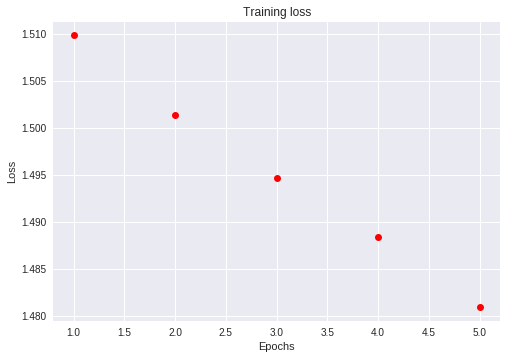

In [0]:
history_dict = history.history # monitoreando loss debe estar bajando 
history_dict.keys()

acc = history.history['acc']
loss = history.history['loss']
epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'ro', label='Training loss')
# b is for "solid blue line"
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

## Conclusiones

- Los modelos RNN con arquitecturas LSTM para generación de lenguaje necesitan gran capacidad de memoria porque van almacenando secuencias de caracteres como un estado interno (Ct), además del tradicional hidden state (Ht).

- La útima capa de nuestra red neuronal utiliza una función softmax que normaliza las salidas entre 0 y 1 asignando probabilidades decimales a cada clase en un caso de clases múltiples. 
Se utiliza en problemas de clases excluyentes o en donde solo una clase es posible. Para tener resultados diversos en la generación de texto, la última capa toma los valores aleatorios de la distribución de probabilidad.

- El parámetro de temperature nos permitió obtener mayor diversidad de vocabulario cuando toma valores mayores a 1. Sin embargo en ciertos ejemplos se forman mal las palabras. Cuando el valor va entre 0 y 1 hay muy buena capacidad de generar palabras sin errores porque se toman los caracteres en función de la distribución de probabilidad dada por softmax.



## Entregable

Completa los apartados anteriores para entrenar modelos del lenguaje que sean capaces de generar texto con cierto sentido. Comentar los resultados obtenidos y cómo el modelo va mejorando época a época. Comentar las diferencias apreciadas al utilizar diferentes valores de temperatura. Entregar al menos la salida de un entrenamiento completo con los textos generados época a época.

El objetivo no es conseguir generar pasajes literarios con coherencia, sino obtener lenguaje que se asemeje en cierta manera a lo visto en el texto original y donde las palabras sean reconocibles como construcciones en castellano. Como ejemplo de lo que se puede conseguir, este es el resultado de generar texto después de 10 epochs y con temperature 0.2:


```
-----> Epoch: 10 - Generando texto con temperature 0.2
Seed: o le cautivaron y rindieron el
Texto generado: o le cautivaron y rindieron el caballero de la caballería de la mano de la caballería del cual se le dijo:

-¿quién es el verdad de la caballería de la caballería de la caballería de la caballería de la caballería, y me ha de habían de la mano que el caballero de la mano de la caballería. y que no se le habían de la mano de la c

```

Asimismo, se proponen los siguientes aspectos opcionales para conseguir nota extra:

*   Experimentar con los textos de teatro en verso de Calderón de la Barca (¿es capaz el modelo de aprender las estructuras del teatro en verso?) o con alguno de los otros textos disponibles. También se puede probar con textos de vuestra elección.
*   Experimentar con distintos valores de SEQ_LENGTH.
*   Experimentar con los hiperparámetros del modelo o probar otro tipo de modelos como GRUs o *stacked* RNNs (RNNs apiladas).
*   Experimentar utilizando embeddings en vez de representaciones one-hot.
*   (Difícil) Entrenar un modelo secuencia a secuencia en vez de secuencia a carácter.




## Modelo con arquitectura GRU, con texto en verso de Calderón de la Barca

In [0]:
# Se descarga el texto en verso de Calderón de la Barca

path = keras.utils.get_file(
    fname="Teatro Calderón.txt", 
    origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219433&authkey=AKvGD6DC3IRBqmc"
)

In [0]:
text = open(path,"r", encoding = 'utf-8').read().lower() # abrir archivo, leer archivo, y pasar todo a minusculas, acentos (utf-8)

In [0]:
#¿a que nos enfrentamos, ¿cómo es la data?
print("Longitud del texto:", len(text), "caracteres")

print(text[0:300]) # Muestra archivo 300 caracteres

Longitud del texto: 401338 caracteres
dramas religiosos y filosóficos.




la vida es sueño.




personas.


  basilio, _rey de polonia_.
  segismundo, _príncipe_.
  astolfo, _duque de moscovia_.
  clotaldo, _viejo_.
  clarin, _gracioso_.
  estrella, _infanta_.
  rosaura, _dama_.
  _soldados._
  _guardas._
  _músicos._
  _acompañamiento


## Procesado de datos

In [0]:
# 1. Número de caracteres únicos que aparecen en el texto

chars = sorted(set(text)) # total de caracteres únicos-> crea un conjunto no tiene elemento repetidos y lo ordenamos, tokenización pero con caracteres!
print('Total de carácteres únicos:', len(chars))
print (chars)

# 2. Diccionario que asocia char a índice único entre 0 y num_chars - 1. Por ejemplo, {'a': 0, 'b': 1, ...}

char_index = dict((c, i) for i, c in enumerate(chars)) 
print ("\nDiccionario caracter(char) - indice(int):", char_index)

# 3. Diccionario reverso de índices a caracteres: {0: 'a', 1: 'b', ...}

index_char = dict((i, c) for i, c in enumerate(chars))
print ("\nDiccionario indice(int) - caracter(char): ", index_char)

Total de carácteres únicos: 66
['\n', ' ', '!', '(', ')', '*', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'x', 'y', 'z', '}', '¡', '«', 'º', '»', '¿', 'á', 'é', 'ê', 'í', 'ï', 'ñ', 'ó', 'ô', 'ú', 'ü', '—']

Diccionario caracter(char) - indice(int): {'\n': 0, ' ': 1, '!': 2, '(': 3, ')': 4, '*': 5, ',': 6, '-': 7, '.': 8, '0': 9, '1': 10, '2': 11, '3': 12, '4': 13, '5': 14, '6': 15, '7': 16, '8': 17, '9': 18, ':': 19, ';': 20, '?': 21, '[': 22, ']': 23, '_': 24, 'a': 25, 'b': 26, 'c': 27, 'd': 28, 'e': 29, 'f': 30, 'g': 31, 'h': 32, 'i': 33, 'j': 34, 'l': 35, 'm': 36, 'n': 37, 'o': 38, 'p': 39, 'q': 40, 'r': 41, 's': 42, 't': 43, 'u': 44, 'v': 45, 'x': 46, 'y': 47, 'z': 48, '}': 49, '¡': 50, '«': 51, 'º': 52, '»': 53, '¿': 54, 'á': 55, 'é': 56, 'ê': 57, 'í': 58, 'ï': 59, 'ñ': 60, 'ó': 61, 'ô': 62, 'ú': 63, 'ü': 64, '—': 65}

Diccion

In [0]:
# Definimos el tamaño de las secuencias.

# En este caso se prueba con longitud de 50 en las secuencias

SEQ_LENGTH = 50  
sequences = []
next_chars = []

for i in range(0, len(text) - SEQ_LENGTH, 1): # corrimiento a la izquierda
    sequences.append(text[i: i + SEQ_LENGTH])
    next_chars.append(text[i + SEQ_LENGTH])

In [0]:
# Se muestra la longitud de las secuencias en total

print('Número de enunciados:', len(sequences))

Número de enunciados: 401288
input:  amas religiosos y filosóficos.




la vida es sueñ
output:  o


In [0]:
MAX_SEQUENCES = 400000

perm = np.random.permutation(len(sequences))# produce aletoriedad en la data!
sequences, next_chars = np.array(sequences), np.array(next_chars)
sequences, next_chars = sequences[perm], next_chars[perm]
sequences, next_chars = list(sequences[:MAX_SEQUENCES]), list(next_chars[:MAX_SEQUENCES])

print("MAX_SEQUENCES = ", len(sequences))

MAX_SEQUENCES =  400000
X =  
  animal, planta ni piedra
  que no tenga calidad

y =  



In [0]:
NUM_CHARS = len(chars)  #  número de caracteres distintos aquí
NUM_SEQUENCES = len(sequences)
X = np.zeros((NUM_SEQUENCES, SEQ_LENGTH, NUM_CHARS))
y = np.zeros((NUM_SEQUENCES, NUM_CHARS))
print ("Matriz X =", X.shape)
print ("Matriz y =", y.shape)

for i, sentence in enumerate(sequences):
    for t, char in enumerate(sentence):
        X[i, t, char_index[char]] = 1. 
    y[i, char_index[next_chars[i]]] = 1.

Matriz X = (400000, 50, 66)
Matriz y = (400000, 66)


In [0]:
# módelo RNN con GRU 100

model = Sequential()
model.add(GRU(100, return_sequences=False, input_shape=(SEQ_LENGTH, len(chars))))
model.add(Dropout(0.2))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))


model.compile(loss='categorical_crossentropy', optimizer='Adam',
              metrics=['accuracy'])

# Se muestra el resumen del modelo
  
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 100)               50100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 66)                6666      
_________________________________________________________________
activation_1 (Activation)    (None, 66)                0         
Total params: 56,766
Trainable params: 56,766
Non-trainable params: 0
_________________________________________________________________


In [0]:
print (X.shape)# 400000 secuencias, 50 largo de la frase, 66 vocabulario No caracteres
print (y.shape)# 400000 secuencias, vocabulario

history2 = model.fit(X, y, batch_size=512, epochs=30, callbacks=[generation_callback]) # optimo 30
#model.save("ejemplo_texto_modelo")

(400000, 50, 66)
(400000, 66)
Epoch 1/30
400000/400000 [==============================] - 104s 259us/step - loss: 2.3695 - acc: 0.3294




------> Epoch: 1 - Generando texto con temperature 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


Seed: diente del pecho.

astolfo.

  satisfaceros intent
Texto generado: diente del pecho.

astolfo.

  satisfaceros intent                                                                                                    

------> Epoch: 1 - Generando texto con temperature 0.5
Seed: diente del pecho.

astolfo.

  satisfaceros intent
Texto generado: diente del pecho.

astolfo.

  satisfaceros intente mo mises,
  nuse mi ho al yo cuentias cor jerta,
  le lo dientuen en mi purato, el tiono en verela

------> Epoch: 1 - Generando texto con temperature 1.0
Seed: diente del pecho.

astolfo.

  satisfaceros intent
Texto generado: diente del pecho.

astolfo.

  satisfaceros intentos terate.

ledosa
  agreníta, áderta su talte furta! fimodo)_

  y bes.)_

 ¿que nozorundes asdes.


------> Epoch: 1 - Generando texto con temperature 1.5
Seed: diente del pecho.

astolfo.

  satisfaceros intent
Texto generado: diente del pecho.

astolfo.

  satisfaceros intentezol _,ipzihe
  debres audelerocse.
 

Text(0,0.5,'Loss')

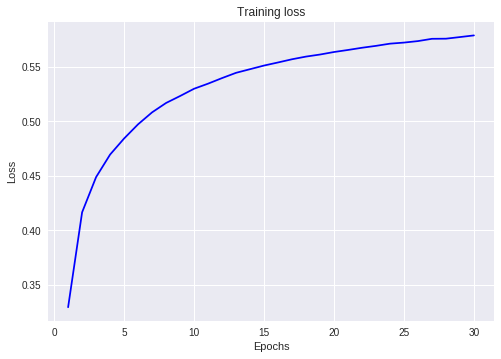

In [0]:
history_dict2 = history2.history
history_dict2.keys()

acc = history2.history['acc']
loss = history2.history['loss']
epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, acc, 'b', label='Training accuracy')
# b is for "solid blue line"
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0,0.5,'Loss')

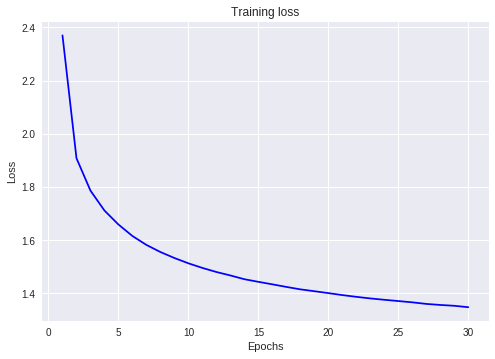

In [0]:
history_dict2 = history2.history # monitoreando loss debe estar bajando 
history_dict2.keys()

acc = history2.history['acc']
loss = history2.history['loss']
epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'b', label='Training loss')
# b is for "solid blue line"
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

## Conclusiones

En este modelo con arquitectura GRU y con el texto en verso de Calderón de la Barca tenemos un error mayor. Al comparar el modelo GRU con el modelo LSTM en 5 épocas, vemos que el modelo GRU alcanza un error de 1,65 mientras que el modelo LSTM tiene un error de 1,48. Importante destacar que los textos con los que se entrenaron ambos modelos es diferente. En este modelo GRU se utilizó texto en verso.

Uno de los motivos por el cual el modelo GRU tiene más error es porque se ha entrenado con un corpus de texto en verso. Los textos en verso siguen una métrica de escritura ceñida por la sonoridad, es decir, se buscan palabras con rima.

Por lo tanto, vemos que este modelo puede formar frases correctas, pero tiene dificultad para armar frases que rimen.